# Online Tracking

Given a list of images, we want to track players and the ball and gather their trajectories. Our model initializes several tracklets based on the detected boxes in the first image. In the following ones, the model links the boxes to the existing tracklets according to: 

1. their distance measured by the embedding model,
2. their distance measured by boxes IoU's

When the entire list of image is processed, we compute an homography for each image. We then apply each homography to the players coordinates.

In [ ]:
# !pip3 install --user tensorflow==2.11.0
# !pip3 install --user tensorflow-probability==0.19.0
# !pip3 install --user dm-sonnet==2.0.0

## Inputs

Let's start by gathering a list of images: 

In [3]:
%env SM_FRAMEWORK=tf.keras

import os
import numpy as np
import torch
import torch.nn.functional as F
import mxnet as mx
import cv2
from matplotlib import pyplot as plt

import sys
sys.path.append("./narya")

from narya.utils.vizualization import visualize

from narya.tracker.full_tracker import FootballTracker

env: SM_FRAMEWORK=tf.keras


/home/rodrigo/anaconda3/envs/narya/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-09 17:25:26.775535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 17:25:27.459325: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rodrigo/anaconda3/envs/narya/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda/extras/CUPTI/lib64,/usr/local/cuda/l

Segmentation Models: using `tf.keras` framework.


First, we initialize a 2d Field template:

In [4]:
template = cv2.imread('world_cup_template.png')
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template = cv2.resize(template, (1280,720))
template = template/255.

and then we create our list of images: 

In [5]:
"""
Images are ordered from 0 to 50:
"""

imgs_ordered = []
for i in range(0,51):
    path = 'test_img/img_fullLeicester 0 - [3] Liverpool.mp4_frame_full_' + str(i) + '.jpg'
    imgs_ordered.append(path)
    
img_list = []
for path in imgs_ordered:
    if path.endswith('.jpg'):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_list.append(image)

We can vizualize the first image of our list: 

Image shape: (512, 512, 3)


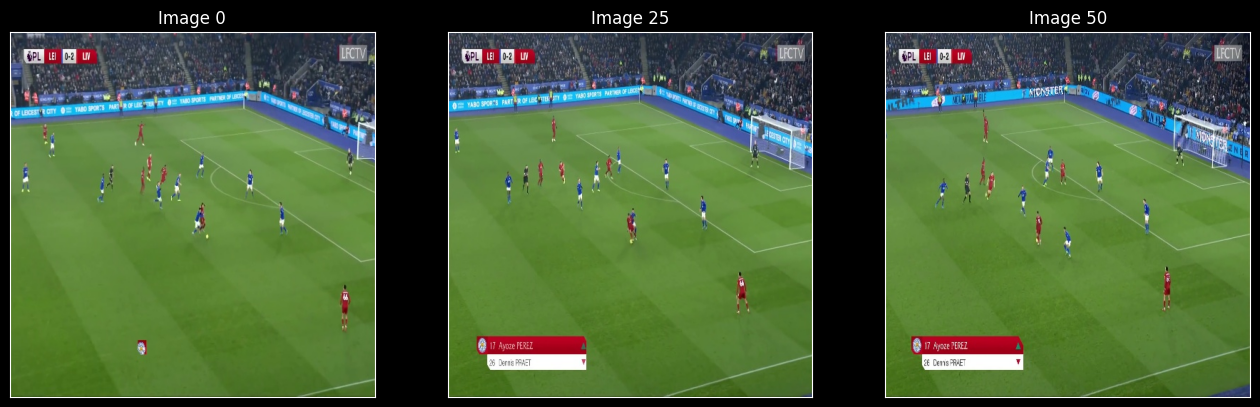

In [6]:
image_0,image_25,image_50 = img_list[0],img_list[25],img_list[50]
print("Image shape: {}".format(image_0.shape))
visualize(image_0=image_0,
            image_25=image_25,
            image_50=image_50)

## Football Tracker

We first need to create our tracker. This object gathers each and every one of our model: 

```python3
class FootballTracker:
"""Class for the full Football Tracker. Given a list of images, it allows to track and id each player as well as the ball.
It also computes the homography at each given frame, and apply it to each player coordinates. 

Arguments:
    pretrained: Boolean, if the homography and tracking models should be pretrained with our weights or not.
    weights_homo: Path to weight for the homography model
    weights_keypoints: Path to weight for the keypoints model
    shape_in: Shape of the input image
    shape_out: Shape of the ouput image
    conf_tresh: Confidence treshold to keep tracked bouding boxes
    track_buffer: Number of frame to keep in memory for tracking reIdentification
    K: Number of boxes to keep at each frames
    frame_rate: -
Call arguments:
    imgs: List of np.array (images) to track
    split_size: if None, apply the tracking model to the full image. If its an int, the image shape must be divisible by this int.
                We then split the image to create n smaller images of shape (split_size,split_size), and apply the model
                to those.
                We then reconstruct the full images and the full predictions.
    results: list of previous results, to resume tracking
    begin_frame: int, starting frame, if you want to resume tracking 
    verbose: Boolean, to display tracking at each frame or not
    save_tracking_folder: Foler to save the tracking images
    template: Football field, to warp it with the computed homographies on to the saved images
    skip_homo: List of int. e.g.: [4,10] will not compute homography for frame 4 and 10, and reuse the computed homography
                at frame 3 and 9.
"""

    def __init__(
        self,
        pretrained=True,
        weights_homo=None,
        weights_keypoints=None,
        shape_in=512.0,
        shape_out=320.0,
        conf_tresh=0.5,
        track_buffer=30,
        K=100,
        frame_rate=30,
    ):

        self.player_ball_tracker = PlayerBallTracker(
            conf_tresh=conf_tresh, track_buffer=track_buffer, K=K, frame_rate=frame_rate
        )

        self.homo_estimator = HomographyEstimator(
            pretrained=pretrained,
            weights_homo=weights_homo,
            weights_keypoints=weights_keypoints,
            shape_in=shape_in,
            shape_out=shape_out,
        )
```

In [7]:
tracker = FootballTracker(frame_rate=24.7,track_buffer = 60)

Creating model...


[17:25:37] ../src/imperative/./imperative_utils.h:93: GPU support is disabled. Compile MXNet with USE_CUDA=1 to enable GPU support.


Succesfully loaded weights from /home/rodrigo/.keras/datasets/player_tracker.params
Succesfully loaded weights from /home/rodrigo/.keras/datasets/player_reid.pth


2023-03-09 17:25:38.704315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 17:25:38.743124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 17:25:38.743432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 17:25:38.744058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Could not load weights from /home/rodrigo/.keras/datasets/deep_homo_model.h5, weights will be loaded Randomly
Succesfully loaded weights from /home/rodrigo/.keras/datasets/keypoint_detector.h5


We now only have to call it on our list of images. We manually remove some failed homography estimation, at frame $\in \{25,...,30 \}$ by adding ```skip_homo = [25,26,27,28,29,30]``` into our call.

In [8]:
trajectories = tracker(img_list,split_size = 512, save_tracking_folder = './test_outputs/',
                        template = template,skip_homo = [25,26,27,28,29,30])

/ |#                                                  | 0 Elapsed Time: 0:00:00
2023-03-09 17:26:00.914012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-03-09 17:26:02.383491: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-09 17:26:02.383562: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-09 17:26:03.350236: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that thi

1/1 [==============================] - 8s 8s/step


2023-03-09 17:26:04.114146: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-09 17:26:04.114215: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-09 17:26:04.223590: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-09 17:26:04.223618: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

1/1 [==============================] - 0s 42ms/step


\ |               #                                   | 2 Elapsed Time: 0:00:08


1/1 [==============================] - 0s 30ms/step


| |              #                                    | 3 Elapsed Time: 0:00:08


1/1 [==============================] - 0s 46ms/step


/ |             #                                     | 4 Elapsed Time: 0:00:08


1/1 [==============================] - 0s 32ms/step


- |           #                                       | 5 Elapsed Time: 0:00:09


1/1 [==============================] - 0s 32ms/step


\ |          #                                        | 6 Elapsed Time: 0:00:09


1/1 [==============================] - 0s 36ms/step


| |         #                                         | 7 Elapsed Time: 0:00:09


1/1 [==============================] - 0s 31ms/step


/ |        #                                          | 8 Elapsed Time: 0:00:09


1/1 [==============================] - 0s 30ms/step


- |       #                                           | 9 Elapsed Time: 0:00:09


1/1 [==============================] - 0s 30ms/step


\ |    #                                             | 10 Elapsed Time: 0:00:09


1/1 [==============================] - 0s 30ms/step


| |   #                                              | 11 Elapsed Time: 0:00:09


1/1 [==============================] - 0s 30ms/step


/ | #                                                | 12 Elapsed Time: 0:00:09


1/1 [==============================] - 0s 30ms/step


- |#                                                 | 13 Elapsed Time: 0:00:09


1/1 [==============================] - 0s 31ms/step


\ |#                                                 | 14 Elapsed Time: 0:00:10


1/1 [==============================] - 0s 34ms/step


| | #                                                | 15 Elapsed Time: 0:00:10


1/1 [==============================] - 0s 30ms/step


/ |  #                                               | 16 Elapsed Time: 0:00:10


1/1 [==============================] - 0s 30ms/step


- |    #                                             | 17 Elapsed Time: 0:00:10


1/1 [==============================] - 0s 33ms/step


\ |     #                                            | 18 Elapsed Time: 0:00:10


1/1 [==============================] - 0s 29ms/step


| |      #                                           | 19 Elapsed Time: 0:00:10


1/1 [==============================] - 0s 33ms/step


/ |       #                                          | 20 Elapsed Time: 0:00:10


1/1 [==============================] - 0s 30ms/step


- |        #                                         | 21 Elapsed Time: 0:00:10


1/1 [==============================] - 0s 30ms/step


\ |         #                                        | 22 Elapsed Time: 0:00:10


1/1 [==============================] - 0s 29ms/step


| |          #                                       | 23 Elapsed Time: 0:00:11


1/1 [==============================] - 0s 32ms/step


/ |            #                                     | 24 Elapsed Time: 0:00:11


1/1 [==============================] - 0s 38ms/step


- |             #                                    | 25 Elapsed Time: 0:00:11


1/1 [==============================] - 0s 30ms/step


\ |              #                                   | 32 Elapsed Time: 0:00:11


1/1 [==============================] - 0s 30ms/step


| |               #                                  | 33 Elapsed Time: 0:00:11


1/1 [==============================] - 0s 32ms/step


/ |                #                                 | 34 Elapsed Time: 0:00:11


1/1 [==============================] - 0s 29ms/step


- |                 #                                | 35 Elapsed Time: 0:00:11


1/1 [==============================] - 0s 31ms/step


\ |                   #                              | 36 Elapsed Time: 0:00:11


1/1 [==============================] - 0s 40ms/step


| |                    #                             | 37 Elapsed Time: 0:00:12


1/1 [==============================] - 0s 36ms/step


/ |                     #                            | 38 Elapsed Time: 0:00:12


1/1 [==============================] - 0s 31ms/step


- |                      #                           | 39 Elapsed Time: 0:00:12


1/1 [==============================] - 0s 41ms/step


\ |                        #                         | 40 Elapsed Time: 0:00:12


1/1 [==============================] - 0s 33ms/step


| |                         #                        | 41 Elapsed Time: 0:00:12


1/1 [==============================] - 0s 33ms/step


/ |                          #                       | 42 Elapsed Time: 0:00:12


1/1 [==============================] - 0s 32ms/step


- |                           #                      | 43 Elapsed Time: 0:00:12


1/1 [==============================] - 0s 34ms/step


\ |                            #                     | 44 Elapsed Time: 0:00:12


1/1 [==============================] - 0s 32ms/step


| |                             #                    | 45 Elapsed Time: 0:00:12


1/1 [==============================] - 0s 31ms/step


/ |                               #                  | 46 Elapsed Time: 0:00:13


1/1 [==============================] - 0s 30ms/step


- |                                #                 | 47 Elapsed Time: 0:00:13


1/1 [==============================] - 0s 30ms/step


\ |                                 #                | 48 Elapsed Time: 0:00:13


1/1 [==============================] - 0s 29ms/step


| |                                  #               | 49 Elapsed Time: 0:00:13


1/1 [==============================] - 0s 30ms/step


/ |                                    #             | 50 Elapsed Time: 0:00:13


1/1 [==============================] - 0s 37ms/step


| |                                     #            | 50 Elapsed Time: 0:00:13


===========Frame 1==========
Activated: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Refind: []
Lost: []
Removed: []
===========Frame 2==========
Activated: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Refind: []
Lost: []
Removed: []
===========Frame 3==========
Activated: [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12]
Refind: []
Lost: [8]
Removed: []
===========Frame 4==========
Activated: [1, 2, 3, 4, 5, 6, 7, 9, 11, 12]
Refind: []
Lost: [10]
Removed: []
===========Frame 5==========
Activated: [1, 2, 3, 4, 5, 6, 7, 9, 11, 13]
Refind: [8, 10]
Lost: [12]
Removed: []
===========Frame 6==========
Activated: [1, 2, 3, 4, 5, 6, 7, 9, 11, 8, 10, 13, 14]
Refind: []
Lost: []
Removed: []
===========Frame 7==========
Activated: [1, 3, 4, 5, 6, 7, 9, 11, 13, 8, 2]
Refind: [12]
Lost: [10]
Removed: [14]
===========Frame 8==========
Activated: [3, 4, 5, 6, 7, 9, 11, 13, 8, 12, 1, 2, 15]
Refind: [10]
Lost: []
Removed: []
===========Frame 9==========
Activated: [1, 3, 5, 6, 7, 9, 13, 8, 12, 10, 16]
Refind: []
Lost: [2, 4, 1

  0% (0 of 51) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (51 of 51) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


===========Frame 51==========
Activated: [1, 3, 9, 20, 4, 7, 13, 24, 5, 10, 8]
Refind: [17]
Lost: []
Removed: []


## Saving trajectories

In [10]:
import json

with open('trajectories.json', 'w') as outfile:
    json.dump(trajectories, outfile)

Let's check the same images as before but with the tracking informations: 

Image shape: (512, 512, 3)


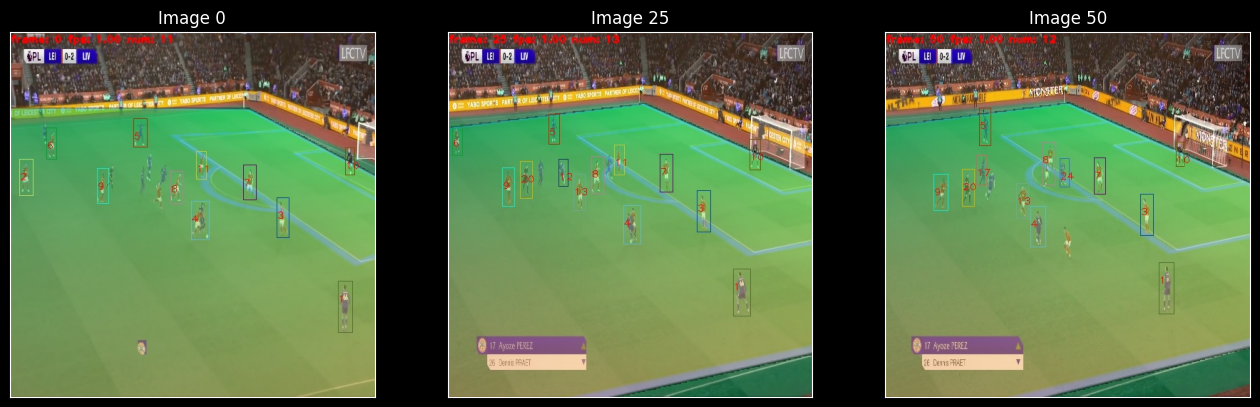

In [11]:
imgs_ordered = []
for i in range(0,51):
    path = 'test_outputs/test_' + '{:05d}'.format(i) + '.jpg'

    imgs_ordered.append(path)
    
img_list = []
for path in imgs_ordered:
    if path.endswith('.jpg'):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_list.append(image)

image_0,image_25,image_50 = img_list[0],img_list[25],img_list[50]
print("Image shape: {}".format(image_0.shape))
visualize(image_0=image_0,
            image_25=image_25,
            image_50=image_50)

You can also easily create a movie of the tracking data, and display it: 

In [12]:
import imageio
import progressbar
with imageio.get_writer('test_outputs/movie.mp4', mode='I',fps=20) as writer:
    for i in progressbar.progressbar(range(0,51)):
        filename = 'test_outputs/test_{:05d}.jpg'.format(i)
        image = imageio.imread(filename)
        writer.append_data(image)

  0% (0 of 51) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (1 of 51) |                         | Elapsed Time: 0:00:00 ETA:   0:00:31
 15% (8 of 51) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:27
 50% (26 of 51) |############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 80% (41 of 51) |###################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 92% (47 of 51) |######################  | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (51 of 51) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [ ]:
%%HTML
<div align="middle">
<video width="80%" controls>
      <source src="test_outputs/movie.mp4" type="video/mp4">
</video></div>

##  Process trajectories 

We now have raw trajectories that we need to process. 
Fist, you can do several operations to ensure that the trajectories are good: 

* Delete an id at a certain frame
* Delete an id from every frame
* Merge two ids 
* Add an id at a given frame

These operation are easy to do with some of our functions from ```narya.utils.tracker```: 

```python3
def _remove_coords(traj, ids, frame):
    """Remove the x,y coordinates of an id at a given frame
    Arguments:
        traj: Dict mapping each id to a list of trajectory
        ids: the id to target
        frame: int, the frame we want to remove
    Returns:
        traj: Dict mapping each id to a list of trajectory
    Raises:
    """
    
def _remove_ids(traj, list_ids):
    """Remove ids from a trajectory
    Arguments:
        traj: Dict mapping each id to a list of trajectory
        list_ids: List of id
    Returns:
        traj: Dict mapping each id to a list of trajectory
    Raises:
    """
    
def add_entity(traj, entity_id, entity_traj):
    """Adds a new id with a trajectory 
    Arguments:
        traj: Dict mapping each id to a list of trajectory
        entity_id: the id to add
        entity_traj: the trajectory linked to entity_id we want to add
    Returns:
        traj: Dict mapping each id to a list of trajectory
    Raises:
    """
    
def add_entity_coords(traj, entity_id, entity_traj, max_frame):
    """Add some coordinates to the trajectory of a given id
    Arguments:
        traj: Dict mapping each id to a list of trajectory
        entity_id: the id to target
        entity_traj: List of (x,y,frame) to add to the trajectory of entity_id
        max_frame: int, the maximum number of frame in trajectories
    Returns:
        traj: Dict mapping each id to a list of trajectory
    Raises:
    """
    

def merge_id(traj, list_ids_frame):
    """Merge trajectories of different ids. 
    e.g.: (10,0,110),(12,110,300) will merge the trajectory of 10 between frame 0 and 110 to the 
        trajectory of 12 between frame 110 and 300.
    Arguments:
        traj: Dict mapping each id to a list of trajectory
        list_ids_frame: List of (id,frame_start,frame_end)
    Returns:
        traj: Dict mapping each id to a list of trajectory
    Raises:
    """
    
def merge_2_trajectories(traj1, traj2, id_mapper, max_frame_traj1):
    """Merge 2 dict of trajectories, if you want to merge the results of 2 tracking
    Arguments:
        traj1: Dict mapping each id to a list of trajectory
        traj2: Dict mapping each id to a list of trajectory
        id_mapper: A dict mapping each id in traj1 to id in traj2
        max_frame_traj1: Maximum number of frame in the first trajectory
    Returns:
        traj1: Dict mapping each id to a list of trajectory
    Raises:
    """
```

here, let's assume we don't have to perform any operations, and directly process our trajectoris into a Pandas Dataframe. 

First, we can save our raw trajectory with

```python3
import json

with open('trajectories.json', 'w') as fp:
    json.dump(trajectories, fp)
```

Let's start by padding our trajectories with np.nan and building a dict. for our dataframe: 

In [13]:
import json

with open('trajectories.json') as json_file:
    trajectories = json.load(json_file)

In [14]:
from narya.utils.tracker import build_df_per_id

df_per_id = build_df_per_id(trajectories)

We now fill the missing values, and apply a filter to smooth the trajectories: 

In [15]:
from narya.utils.tracker import fill_nan_trajectories

df_per_id = fill_nan_trajectories(df_per_id,5)

In [16]:
from narya.utils.tracker import get_full_results

df = get_full_results(df_per_id)

## Trajectory Dataframe

We now have access to a dataframe with for each id, for each frame, the 2D coordinates of the entity.

In [17]:
df.head()

,id,x,y
frame,,,
1,1,78.200329,10.123497
2,1,78.317181,10.709310
3,1,78.293771,10.685495
4,1,78.356378,10.898973
5,1,78.369653,10.958203


Finally, this you can save this dataframe using ```df.to_csv('results_df.csv')```